In [4]:
!pip install btrdb

     |████████████████████████████████| 81kB 3.0MB/s 
     |████████████████████████████████| 2.5MB 6.9MB/s 


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize

import btrdb
from btrdb.utils.timez import ns_delta, ns_to_datetime, to_nanoseconds

##  Connecting to the API
Visit your profile on ni4ai.org to get an API key.

In [6]:
YOUR_API_KEY = 'YOUR API KEY GOES HERE'
URL = "api.ni4ai.org:4411"

#Establishing the connecting to the server
db = btrdb.connect(URL, apikey=YOUR_API_KEY)


In [7]:
#View streams in the collection
db.list_collections("lndunn/PQdata")


['lndunn/PQdata/underground']

In [8]:
#Choose streams for a particular collection
streams = db.streams_in_collection('lndunn/PQdata/underground')
streams

[<Stream collection=lndunn/PQdata/underground name=phB_volt>,
 <Stream collection=lndunn/PQdata/underground name=phB_amp>,
 <Stream collection=lndunn/PQdata/underground name=phC_volt>,
 <Stream collection=lndunn/PQdata/underground name=phA_amp>,
 <Stream collection=lndunn/PQdata/underground name=phC_amp>,
 <Stream collection=lndunn/PQdata/underground name=phA_volt>]

In [9]:
# Print metadata (tags, annotations) for the first stream in the collection
print(streams[0].tags())
print(streams[0].annotations())

{'ingress': '', 'distiller': '', 'name': 'phB_volt', 'unit': 'volts'}
({'source': 'https://drive.google.com/drive/folders/0B6vSVhUYNe86TGQ3bmgwdG1ySnM', 'documentation': 'https://grouper.ieee.org/groups/td/pq/data/downloads/XLPE_data.pdf', 'equipment_specs': '{"cable type": "XLPE underground cable", "cable rating": "8 kV", "Year of installation": "1991", "PT ratio": "8050:115", "CT ratio": "600:5"}', 'measurement_params': '{"Sampling mode": "Continuous (gap-less) data recording", "Sampling rate": "64 samples/cycle", "Measured signals": "Three-phase bus voltages and feeder currents"}'}, 7)


In [10]:
# Read the docs
streams[0].annotations()[0]['documentation']

'https://grouper.ieee.org/groups/td/pq/data/downloads/XLPE_data.pdf'

In [11]:
df = pd.DataFrame(columns=['Collection','Name','Units','UUID'])
for ix, stream in enumerate(streams):
  tags = stream.tags()
  df.loc[ix] = [stream.collection, stream.name, tags['unit'], stream.uuid]

df

,Collection,Name,Units,UUID
0,lndunn/PQdata/underground,phB_volt,volts,a63f75e8-38f5-4f2f-8327-8fd8ae94013b
1,lndunn/PQdata/underground,phB_amp,amps,2e08ba24-61ea-4fa7-bb72-24f005150ac2
2,lndunn/PQdata/underground,phC_volt,volts,47dfc415-1704-4447-88a4-43e68645ab0f
3,lndunn/PQdata/underground,phA_amp,amps,9cc032a1-6c32-4c3a-bb37-7c87da13dc4b
4,lndunn/PQdata/underground,phC_amp,amps,33f91f08-ed6f-49fb-a83e-1dc9889d5b36
5,lndunn/PQdata/underground,phA_volt,volts,ca93b50c-612c-4d10-b211-fe98f21ea39c


In [12]:
idx = df['Name'].str.contains('volt')
df[idx]

,Collection,Name,Units,UUID
0,lndunn/PQdata/underground,phB_volt,volts,a63f75e8-38f5-4f2f-8327-8fd8ae94013b
2,lndunn/PQdata/underground,phC_volt,volts,47dfc415-1704-4447-88a4-43e68645ab0f
5,lndunn/PQdata/underground,phA_volt,volts,ca93b50c-612c-4d10-b211-fe98f21ea39c


In [13]:
stream = streams[0]

stream.name

'phB_volt'

In [14]:
start = stream.earliest(version=6642)
print(start)

(RawPoint(1577836800000126720, 12.106108665466309), 6642)


In [17]:
print(ns_to_datetime(start[0][0]))

2020-01-01 00:00:00.000127+00:00


In [18]:
(start_time, start_val), _ = stream.earliest()
(end_time, end_val), _ = stream.latest()

In [19]:
pw = 38
points = stream.aligned_windows(start_time, end_time, pw)
print(len(points))

315


In [20]:
print(points[0])

(StatPoint(1577836569253904384, -157.31466674804688, -0.04172204669137316, 157.37940979003906, 169423, 112.8249708305788), 6655)


In [21]:
points, _ = zip(*stream.aligned_windows(start_time, end_time, pw))

In [22]:
points[10].min, points[10].stddev

(-157.02334594726562, 112.63509226857258)

In [23]:
def get_stats(points, attrs=['time','min','max','mean','stddev','count']):
  df = pd.DataFrame(columns=attrs)
  for i, point in enumerate(points):
    df.loc[i] = [getattr(point, attr) for attr in attrs]
  return df

In [24]:
data = get_stats(points)

In [25]:
data.head()

,time,min,max,mean,stddev,count
0,1.577837e+18,-157.314667,157.379410,-0.041722,112.824971,169423.0
1,1.577837e+18,-157.314667,157.314667,-0.024379,112.833548,1055265.0
2,1.577837e+18,-157.476517,157.444153,-0.027099,112.907396,1139096.0
3,1.577837e+18,-157.152817,157.152817,-0.024968,112.830574,1055264.0
4,1.577838e+18,-157.379410,157.314667,-0.025629,112.873527,1055264.0


In [26]:
df

,Collection,Name,Units,UUID
0,lndunn/PQdata/underground,phB_volt,volts,a63f75e8-38f5-4f2f-8327-8fd8ae94013b
1,lndunn/PQdata/underground,phB_amp,amps,2e08ba24-61ea-4fa7-bb72-24f005150ac2
2,lndunn/PQdata/underground,phC_volt,volts,47dfc415-1704-4447-88a4-43e68645ab0f
3,lndunn/PQdata/underground,phA_amp,amps,9cc032a1-6c32-4c3a-bb37-7c87da13dc4b
4,lndunn/PQdata/underground,phC_amp,amps,33f91f08-ed6f-49fb-a83e-1dc9889d5b36
5,lndunn/PQdata/underground,phA_volt,volts,ca93b50c-612c-4d10-b211-fe98f21ea39c


## Query individual points

In [48]:
dt = ns_delta(seconds=1/60.)
_streams = db.streams(*df['UUID'].tolist())
data = _streams.filter(start_time, start_time+10*dt).to_dataframe()

In [49]:
data.head(n=10)

,lndunn/PQdata/underground/phB_volt,lndunn/PQdata/underground/phB_amp,lndunn/PQdata/underground/phC_volt,lndunn/PQdata/underground/phA_amp,lndunn/PQdata/underground/phC_amp,lndunn/PQdata/underground/phA_volt
time,,,,,,
1577836800000126720,12.106109,-2.190860,130.124481,4.445920,-2.253441,-148.154160
1577836800000387328,-2.524803,-1.774915,139.155502,4.280297,-2.521027,-140.903442
1577836800000647680,-16.378853,-1.312574,147.539154,4.035369,-2.752467,-131.678207
1577836800000908288,-29.585516,-0.812469,153.365616,3.759691,-2.936433,-121.287666
1577836800001168640,-44.701965,-0.367931,155.760941,3.546054,-3.137662,-109.828949
1577836800001429248,-60.433434,0.067436,156.861496,3.373418,-3.412261,-96.881233
1577836800001689600,-75.452774,0.528159,157.508881,3.186755,-3.704663,-82.023743
1577836800001950208,-89.695259,1.032580,157.832581,2.969881,-3.994908,-66.357010
1577836800002210560,-102.772446,1.500855,157.088089,2.717940,-4.204769,-50.755020


In [50]:
data = data.rename(columns=dict(zip(data.keys(), [k.split('/')[-1] for k in data.keys()])))
data.head()

,phB_volt,phB_amp,phC_volt,phA_amp,phC_amp,phA_volt
time,,,,,,
1577836800000126720,12.106109,-2.190860,130.124481,4.445920,-2.253441,-148.154160
1577836800000387328,-2.524803,-1.774915,139.155502,4.280297,-2.521027,-140.903442
1577836800000647680,-16.378853,-1.312574,147.539154,4.035369,-2.752467,-131.678207
1577836800000908288,-29.585516,-0.812469,153.365616,3.759691,-2.936433,-121.287666
1577836800001168640,-44.701965,-0.367931,155.760941,3.546054,-3.137662,-109.828949


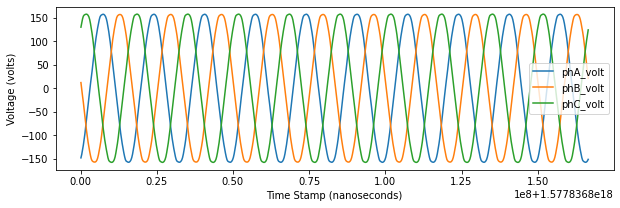

In [77]:
data[['phA_volt','phB_volt','phC_volt']].plot(figsize=(10,3))
plt.xlabel('Time Stamp (nanoseconds)')
plt.ylabel('Voltage (volts)')
plt.show()

In [118]:
def calc_sine(params, t):
  freq, phase, magnitude = params
  return magnitude * np.sin(2*np.pi*freq * t/1e9 - np.radians(phase))

def func(params, t, y):
  return calc_sine(params, t) - y

t = data.index
y = data['phA_volt']

p0 = [60, 0, y.max()]

result = optimize.least_squares(func, p0, args=(t, y))
print(dict(zip(['frequency', 'phase angle', 'magnitude'], result.x)))

{'frequency': 59.99991630108517, 'phase angle': -8.369891483178954e-05, 'magnitude': 157.57066616213953}


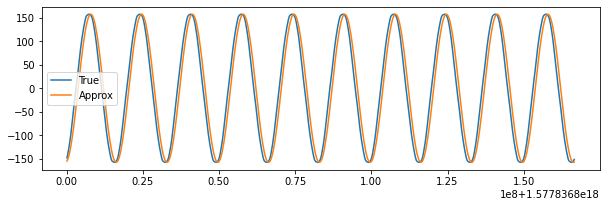

In [119]:
y_hat = calc_sine(result.x, t)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(t, y, label='True')
ax.plot(t, y_hat, label='Approx')
plt.legend()
plt.show()

In [120]:
p0 = {'phA_volt': [60., 0, data['phA_volt'].max()],
      'phB_volt': [60., 120, data['phB_volt'].max()], 
      'phC_volt': [60., -120, data['phC_volt'].max()]}

params = {}
for phase in ['phA_volt', 'phB_volt', 'phC_volt']:
  y = data[phase]
  result = optimize.least_squares(func, p0[phase], args=(t, y), xtol=1e-9)
  params[phase] = result.x

In [121]:
params

{'phA_volt': array([ 5.99999163e+01, -8.36989148e-05,  1.57570666e+02]),
 'phB_volt': array([ 60.00001931, 120.00001931, 156.98022894]),
 'phC_volt': array([  60.00000886, -119.99999114,  157.85239831])}